# Analysis Layout

1. Which words change the most and the least?
- 1990-2019: align yearly models consecutevily, semantic swift per POS families, semantic swift for words woth specific word ending,   




In [148]:
from gensim.models import Word2Vec
from tqdm import tqdm
import tqdm.notebook as tq
import pandas as pd
import nltk
import numpy as np
import gensim
import datetime
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
nltk.download('punkt')
tqdm.pandas()

[nltk_data] Downloading package punkt to /Users/furiosa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [149]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')
df = df[df['speech'].notna()]
df.speech = df.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])

100%|██████████| 1274505/1274505 [03:42<00:00, 5719.75it/s] 


In [150]:
# in csv date is a string 03/07/1989 	set format="%d/%m/%Y" to convert to yy-mm-dd: 1989-07-03
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.head(2)

member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   1989-07-03             period 5   
1  κρητικος νικολαου παναγιωτης   1989-07-03             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech  
0   προεδρευων  [[παρακαλειται, @sw, γραμματεας, βουλγαρακης, ...  
1   προεδρευων  [[παρακαλειται, @sw, κυριος, γραμματεας, @sw, ...

# 1. Which words change the most and the least

Description: train yearly models for 1989 and 2019. find common vocab and compute cosine for each word. print top and bottom words

In [9]:
from tqdm import tqdm
tqdm.pandas()

#New column year
df['year'] = df['sitting_date'].dt.year
print(datetime.datetime.now())
#Group speeches by year
PERyear_df = df.copy().groupby(df.year)['speech'].progress_apply(sum).reset_index()
print(datetime.datetime.now())



/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/31 [00:00<?, ?it/s]

2021-02-03 02:13:59.459476


100%|██████████| 31/31 [1:08:32<00:00, 132.68s/it]


2021-02-03 03:22:34.041598


Train yearly models

In [10]:
models_dir =  '../out_files/wordmodels/PERyear/'

# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

# for year, texts in tqdm(zip(PERyear_df.index, PERyear_df.speech)):
#     model = Word2Vec(sentences=texts, size=100, window=5, min_count=1, workers=4)
#     model.save(models_dir+str(year) + ".mdl")

##### Procrustes

In [112]:
import numpy as np
import gensim

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    base_embed.init_sims()
    other_embed.init_sims()

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    # base_vecs = in_base_embed.syn0norm
    base_vecs = in_base_embed.wv.vectors_norm
    # other_vecs = in_other_embed.syn0norm
    other_vecs = in_other_embed.wv.vectors_norm
    
    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm) by "ortho"
    # other_embed.syn0norm = other_embed.syn0 = (other_embed.syn0norm).dot(ortho)
    other_embed.wv.vectors_norm = other_embed.wv.vectors = (other_embed.wv.vectors_norm).dot(ortho)
    return other_embed

def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1, m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count, reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = m.wv.vectors_norm
        new_arr = np.array([old_arr[index] for index in indices])
        # m.syn0norm = m.syn0 = new_arr
        m.wv.vectors_norm = m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.wv.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index, word in enumerate(common_vocab):
            old_vocab_obj = old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1, m2)

Align consecutively every yearly model, beginning from 1990. To do: compare results when all models are aligned with one/the first model.

In [11]:
import tqdm.notebook as tq
import os
import glob
import shutil

years = sorted(PERyear_df.year.to_list())
print(years)

#Create aligned folder
align_dest_dir = models_dir +'/aligned/'
# if not os.path.exists(align_dest_dir):
#     os.makedirs(align_dest_dir)

# for file in glob.glob(models_dir +str(years[0])+'.mdl*'):
#     shutil.copy(file, align_dest_dir)

# m_t0 = Word2Vec.load(models_dir+str(years[0])+'.mdl')

# for year in tq.tqdm(years):
    
#   m_t1 = Word2Vec.load(models_dir+str(year)+'.mdl')
#   m_t1_aligned = smart_procrustes_align_gensim(m_t0, m_t1)
#   m_t1_aligned.save(align_dest_dir+str(year)+'.mdl')
#   m_t0 = m_t1_aligned

[1989, 1990, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


#### Semantic swift for each year compared to the next

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import time

def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])


def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 


def get_common_vocab(list_of_model_ids, directory):
    
    
    models = {l:Word2Vec.load(f"../out_files/wordmodels/{directory}/aligned/{l}.mdl") for l in list_of_model_ids}

    i=0
    for m in models.values():

        i+=1
        if i==1:
            common_vocab = list(set(m.wv.vocab.keys())) #or else intersection would be 0
        else:
            common_vocab = intersection(common_vocab,m.wv.vocab.keys())
            
    return common_vocab

In [14]:
def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

years = sorted(PERyear_df.year.to_list())
year_pairs = step_one_pairs(years)

swifts_PERyear_list=[]

aligned_models_per_year = {y:Word2Vec.load(align_dest_dir+str(y)+'.mdl') for y in years}


for pair in tqdm(year_pairs):
    
    common_vocab = get_common_vocab(pair, "PERyear/")
    print(len(common_vocab))
    
    for word in tq.tqdm(common_vocab):

        cos_sim = compute_cosine_similarity(aligned_models_per_year[pair[0]], aligned_models_per_year[pair[1]], word)
        swifts_PERyear_list.append([pair, word, cos_sim, len(common_vocab)])
                    
    


  0%|          | 0/30 [00:00<?, ?it/s]

42243


  3%|▎         | 1/30 [00:19<09:34, 19.80s/it]


38388


  7%|▋         | 2/30 [00:36<08:49, 18.92s/it]


36848


 10%|█         | 3/30 [00:51<08:01, 17.82s/it]


35223


 13%|█▎        | 4/30 [01:06<07:19, 16.89s/it]


33281


 17%|█▋        | 5/30 [01:20<06:41, 16.06s/it]


27458


 20%|██        | 6/30 [01:33<05:58, 14.95s/it]


27137


 23%|██▎       | 7/30 [01:44<05:21, 13.97s/it]


26238


 27%|██▋       | 8/30 [01:55<04:48, 13.10s/it]


25983


 30%|███       | 9/30 [02:06<04:22, 12.49s/it]


25322


 33%|███▎      | 10/30 [02:18<04:01, 12.07s/it]


25139


 37%|███▋      | 11/30 [02:28<03:42, 11.72s/it]


24720


 40%|████      | 12/30 [02:39<03:24, 11.37s/it]


24489


 43%|████▎     | 13/30 [02:50<03:10, 11.19s/it]


24143


 47%|████▋     | 14/30 [03:00<02:56, 11.04s/it]


24037


 50%|█████     | 15/30 [03:11<02:41, 10.79s/it]


23886


 53%|█████▎    | 16/30 [03:21<02:28, 10.61s/it]


23776


 57%|█████▋    | 17/30 [04:35<06:24, 29.58s/it]


23706


 60%|██████    | 18/30 [04:45<04:45, 23.81s/it]


23459


 63%|██████▎   | 19/30 [04:55<03:37, 19.77s/it]


23354


 67%|██████▋   | 20/30 [05:06<02:49, 16.95s/it]


23264


 70%|███████   | 21/30 [05:15<02:12, 14.68s/it]


23084


 73%|███████▎  | 22/30 [05:25<01:45, 13.22s/it]


22983


 77%|███████▋  | 23/30 [05:35<01:26, 12.40s/it]


22878


 80%|████████  | 24/30 [05:45<01:08, 11.48s/it]


22578


 83%|████████▎ | 25/30 [05:55<00:55, 11.03s/it]


22462


 87%|████████▋ | 26/30 [06:05<00:42, 10.72s/it]


22353


 90%|█████████ | 27/30 [06:14<00:30, 10.31s/it]


22207


 93%|█████████▎| 28/30 [06:23<00:20, 10.01s/it]


22120


 97%|█████████▋| 29/30 [06:33<00:09,  9.75s/it]


21887


100%|██████████| 30/30 [06:42<00:00, 13.40s/it]

In [17]:
swifts_PERyear_df = pd.DataFrame(swifts_PERyear_list, columns = ['year_pair', 'word', 
                                                                 'semantic_similarity', 'common_voc_size'])
print(swifts_PERyear_df.head())

      year_pair             word  semantic_similarity  common_voc_size
0  (1989, 1990)         σαλαμινα             0.823012            42243
1  (1989, 1990)        γιανναρου             0.738438            42243
2  (1989, 1990)       απεδοθησαν             0.415904            42243
3  (1989, 1990)    πληροφορησετε             0.114973            42243
4  (1989, 1990)  τεχνοοικονομικα             0.813170            42243


In [20]:
print(swifts_PERyear_df.describe())

swifts_PERyear_df = swifts_PERyear_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(swifts_PERyear_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(swifts_PERyear_df.tail(20))
swifts_PERyear_df.to_csv('../out_files/semantic_swifts_per_year.csv', index=False)

       semantic_similarity  common_voc_size
count        784646.000000    784646.000000
mean              0.803663     27219.159827
std               0.172075      6047.541264
min              -0.889211     21887.000000
25%               0.770280     23084.000000
50%               0.858258     24489.000000
75%               0.906099     27458.000000
max               0.991835     42243.000000
Words with the lowest cosine similarity / highest change
           year_pair             word  semantic_similarity  common_voc_size
33853   (1989, 1990)             ρακη            -0.889211            42243
26003   (1989, 1990)       περιστερες            -0.887328            42243
34579   (1989, 1990)        εκεχειρια            -0.881134            42243
36580   (1989, 1990)       ρατσιστικα            -0.856777            42243
13454   (1989, 1990)          america            -0.855772            42243
206473  (1994, 1996)        ιπταμενων            -0.844886            27458
29012   (1989, 

In [17]:
import spacy
import el_core_news_lg
#python -m spacy download el_core_news_lg
nlp = el_core_news_lg.load()


In [21]:
from tqdm import tqdm
tqdm.pandas()

def pos_tag_sentence(sentence):
    pos_tags = [token.pos_ for token in nlp(sentence)]
    return pos_tags

#Capture progress
# tqdm.pandas()

print(swifts_PERyear_df.head())
swifts_PERyear_df['POS'] = swifts_PERyear_df['word'].progress_apply(pos_tag_sentence)
# swifts_PERyear_df.to_csv('../out_files/semantic_swifts_per_year_per_party.csv', index=False)

/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 2/784646 [00:00<12:59:18, 16.78it/s]

          year_pair        word  semantic_similarity  common_voc_size
1626   (1989, 1990)        ρακη            -0.889211            42243
17455  (1989, 1990)  περιστερες            -0.887328            42243
20891  (1989, 1990)   εκεχειρια            -0.881134            42243
18162  (1989, 1990)  ρατσιστικα            -0.856777            42243
40688  (1989, 1990)     america            -0.855772            42243


100%|██████████| 784646/784646 [2:28:23<00:00, 88.12it/s]    


In [27]:
swifts_PERyear_df.to_csv('../out_files/semantic_swifts_per_year.csv', index=False)

In [29]:
# nouns_PERyear_df = swifts_PERyear_df[swifts_PERyear_df.POS.apply(lambda x: 'NOUN' in x)]
# print(nouns_PERyear_df.head(20))

           year_pair            word  semantic_similarity  common_voc_size  \
204905  (1994, 1996)       ιπταμενων            -0.844886            27458   
2786    (1989, 1990)    επιθεωρησεων            -0.817678            42243   
232141  (1996, 1997)       ιπταμενων            -0.796823            27137   
4581    (1989, 1990)  προστατευομενο            -0.761096            42243   
201268  (1994, 1996)           εξοχη            -0.705730            27458   
77192   (1990, 1991)        ελβετικη            -0.695103            38388   
30199   (1989, 1990)      προσλαβαμε            -0.694689            42243   
187883  (1994, 1996)           8μηνο            -0.679299            27458   
205764  (1994, 1996)          νυξεις            -0.678782            27458   
20890   (1989, 1990)  μεταρρυθμισεων            -0.677102            42243   
190957  (1994, 1996)         αριστων            -0.626866            27458   
228848  (1996, 1997)        αληθειων            -0.625770       

In [32]:
# ismos_swift = swifts_PERyear_df.loc[(swifts_PERyear_df.word.str.endswith('ισμος'))]
# print(ismos_swift.head(20))
# print(ismos_swift.tail(20))

           year_pair             word  semantic_similarity  common_voc_size  \
203815  (1994, 1996)     ευαγγελισμος            -0.498436            27458   
33757   (1989, 1990)      φαρισαισμος            -0.256477            42243   
9834    (1989, 1990)        ρεαλισμος            -0.208843            42243   
80489   (1990, 1991)    παραγκωνισμος            -0.186364            38388   
37642   (1989, 1990)     αναχρονισμος            -0.121720            42243   
18690   (1989, 1990)        αφανισμος            -0.110765            42243   
42092   (1989, 1990)    παραγκωνισμος            -0.106977            42243   
204710  (1994, 1996)     παραλογισμος            -0.106431            27458   
231948  (1996, 1997)     παραλογισμος            -0.089223            27137   
231061  (1996, 1997)     ευαγγελισμος            -0.059718            27137   
13525   (1989, 1990)       αφοπλισμος             0.000994            42243   
63724   (1990, 1991)    ανακαθορισμος             0.

In [11]:
import ast
swifts_PERyear_df = pd.read_csv('../out_files/semantic_swifts_per_year.csv', converters={"year_pair": ast.literal_eval})
print(swifts_PERyear_df.head(2))

      year_pair        word  semantic_similarity  common_voc_size
0  (1989, 1990)        ρακη            -0.889211            42243
1  (1989, 1990)  περιστερες            -0.887328            42243


Distribution

/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='semantic_similarity', ylabel='Density'>

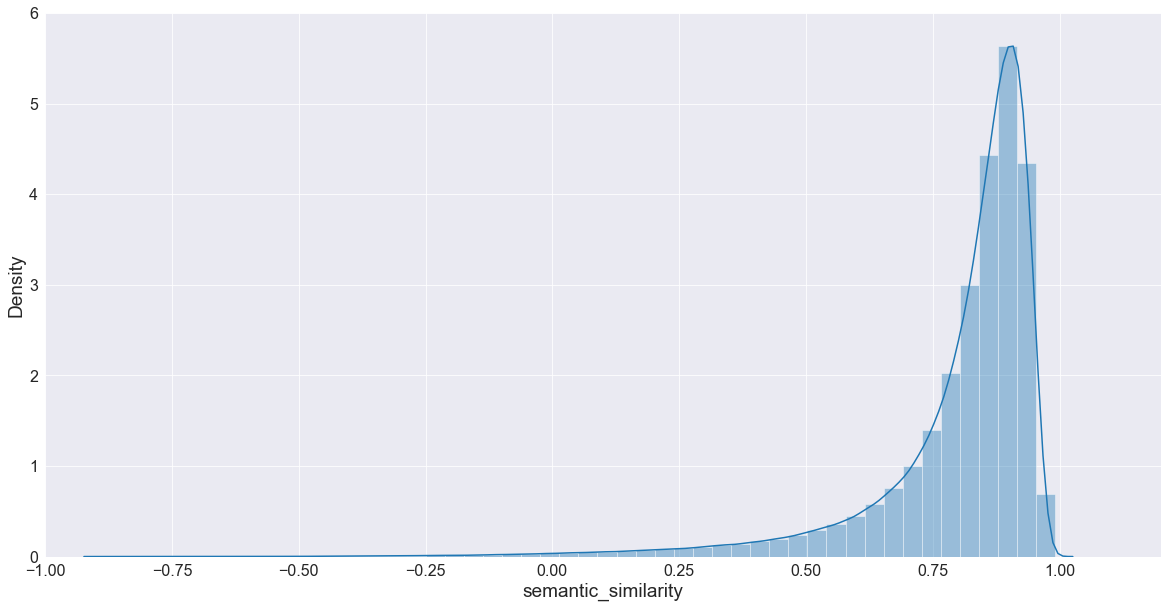

In [145]:
from matplotlib import rcParams
import seaborn as sns
sns.set_style("darkgrid")
fig = plt.figure()
fig.set_size_inches(20, 10)
plt.rcParams['axes.labelsize'] = 19
plt.xlim([-1,1.2])
plt.ylim([0,6])
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

sns.distplot(swifts_PERyear_df.semantic_similarity)

Visualize average cosine similarities through years

In [78]:
sim_mean_per_year = swifts_PERyear_df.copy()
sim_mean_per_year = sim_mean_per_year.groupby(['year_pair']).agg({'semantic_similarity':'mean', 
#                          'c':'sum', 
                         'common_voc_size': lambda x: pd.Series.unique(x)
                                                                 })
# print(sim_mean_per_year.columns)
sim_mean_per_year = pd.DataFrame({'year_pair':sim_mean_per_year.index, 
                                  'mean_sim':sim_mean_per_year.semantic_similarity,
                                 'common_voc_size': sim_mean_per_year.common_voc_size
                                 }, index=None)
print(((sim_mean_per_year.columns)))
print((sim_mean_per_year.head(2)))

Index(['year_pair', 'mean_sim', 'common_voc_size'], dtype='object')
                 year_pair  mean_sim  common_voc_size
year_pair                                            
(1989, 1990)  (1989, 1990)  0.699216            42243
(1990, 1991)  (1990, 1991)  0.770520            38388


In [107]:
print((sim_mean_per_year.common_voc_size.values.tolist()))

[42243, 38388, 36848, 35223, 33281, 27458, 27137, 26238, 25983, 25322, 25139, 24720, 24489, 24143, 24037, 23886, 23776, 23706, 23459, 23354, 23264, 23084, 22983, 22878, 22578, 22462, 22353, 22207, 22120, 21887]


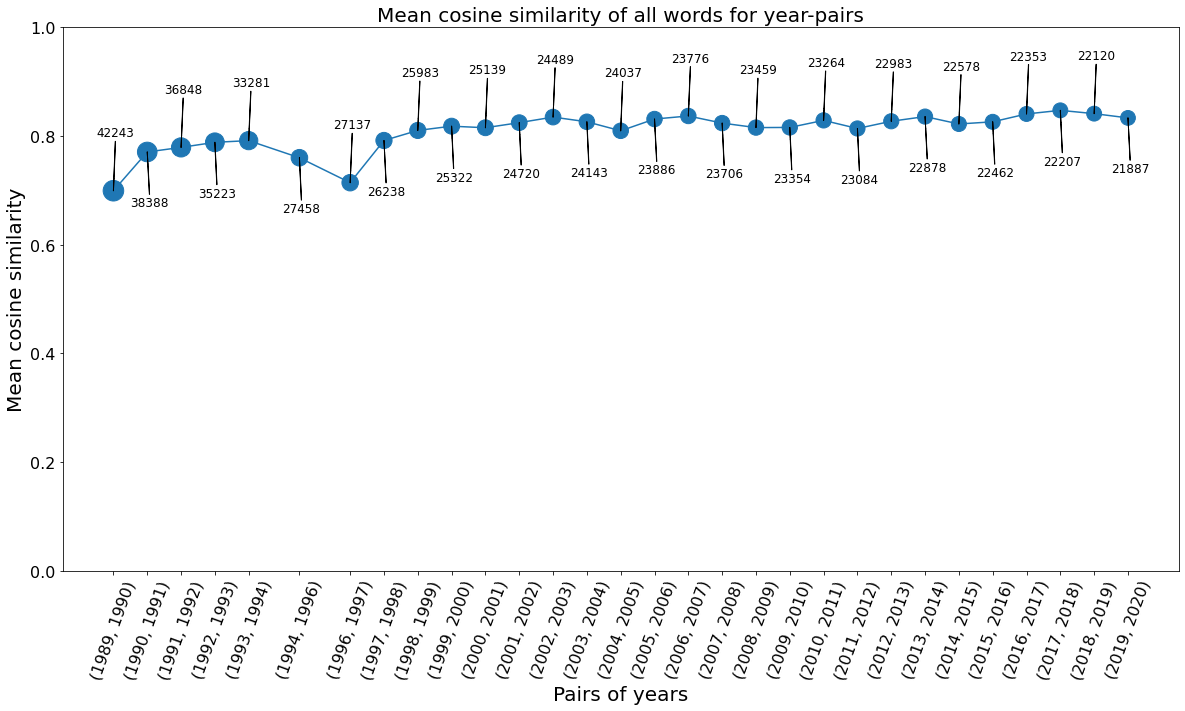

In [140]:
plt.figure(figsize=(20, 10)) 
# sim_mean_per_period = sim_mean_per_period.drop([1,4,9,12,16])
# for x,y in zip(sim_mean_per_period.years, sim_mean_per_period.mean_sim):
# plt.rcParams['axes.labelsize'] = 10
# plt.rcParams.update({'font.size': 10})
# print(sim_mean_per_year)

X = [(y[0]+y[1])/2 for y in sim_mean_per_year.year_pair.to_list()]
Y = sim_mean_per_year.mean_sim.to_list()
voc_size = [sim_mean_per_year.common_voc_size/100]

plt.scatter(X,Y, s=voc_size)
plt.xticks([(y[0]+y[1])/2 for y in sim_mean_per_year.year_pair.to_list()],sim_mean_per_year.year_pair.to_list(), rotation=70)

i=0
for size,x,y in zip(sim_mean_per_year.common_voc_size.values.tolist(), X,Y):
    if i%2==0:
        addy=0.1
    else:
        addy=-0.1
    plt.annotate(size, xy = (x,y), fontsize=12, xytext=(x-0.5, y+addy), arrowprops=dict(facecolor='black',
                                                                                       headwidth=0,
                                                                                       width=0.2))
    i+=1
    
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

plt.ylim((0,1))

plt.title('Mean cosine similarity of all words for year-pairs', fontsize=20)
plt.ylabel('Mean cosine similarity', fontsize=20)
plt.xlabel('Pairs of years', fontsize=20)
plt.plot(X,Y)

### Results per decade

In [27]:
decades = [1990,2000,2010,2019]
decade_pairs = step_one_pairs(decades)
decade_pairs.append((1990,2019))

swifts_PERdecade_list=[]

aligned_models_per_decade = {d:Word2Vec.load(align_dest_dir+str(d)+'.mdl') for d in decades}


for pair in tqdm(decade_pairs):
    
    common_vocab = get_common_vocab(pair, "PERyear/")
    print(len(common_vocab))
    
    for word in tq.tqdm(common_vocab):

        cos_sim = compute_cosine_similarity(aligned_models_per_decade[pair[0]], aligned_models_per_decade[pair[1]], word)
        swifts_PERdecade_list.append([pair, word, cos_sim, len(common_vocab)])
                    

  0%|          | 0/4 [00:00<?, ?it/s]

25322


 25%|██▌       | 1/4 [00:13<00:39, 13.12s/it]


23354


 50%|█████     | 2/4 [00:26<00:26, 13.06s/it]


22120


 75%|███████▌  | 3/4 [00:35<00:12, 12.13s/it]


22120


100%|██████████| 4/4 [00:47<00:00, 11.97s/it]

In [28]:
swifts_PERdecade_df = pd.DataFrame(swifts_PERdecade_list, columns = ['decade_pair', 'word', 
                                                                 'semantic_similarity', 'common_voc_size'])
print(swifts_PERdecade_df.head())

    decade_pair           word  semantic_similarity  common_voc_size
0  (1990, 2000)       σαλαμινα             0.931530            25322
1  (1990, 2000)  πληροφορησετε             0.485523            25322
2  (1990, 2000)   αποκαλυπτικη             0.887872            25322
3  (1990, 2000)    μελλοντικες             0.893334            25322
4  (1990, 2000)       κατοχους             0.966399            25322


In [29]:
print(swifts_PERdecade_df.describe())

swifts_PERdecade_df = swifts_PERdecade_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(swifts_PERdecade_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(swifts_PERdecade_df.tail(20))
swifts_PERdecade_df.to_csv('../out_files/semantic_swifts_per_decade.csv', index=False)

       semantic_similarity  common_voc_size
count         92916.000000     92916.000000
mean              0.795134     23302.787464
std               0.142461      1333.387914
min              -0.575140     22120.000000
25%               0.755341     22120.000000
50%               0.832792     23354.000000
75%               0.883488     25322.000000
max               0.985327     25322.000000
Words with the lowest cosine similarity / highest change
        decade_pair           word  semantic_similarity  common_voc_size
11600  (1990, 2000)          συρει            -0.575140            25322
31149  (2000, 2010)       διαφανει            -0.558690            23354
21207  (1990, 2000)     κραδασμους            -0.546715            25322
1118   (1990, 2000)      μεροληψια            -0.508315            25322
4538   (1990, 2000)   προσεγγισαμε            -0.495963            25322
1851   (1990, 2000)  παρατεινομενη            -0.466821            25322
32028  (2000, 2010)      μεριμνησε  

In [62]:
from tabulate import tabulate

for pair in tqdm(decade_pairs):
    neighbor_change = []
    print(pair)
    subdf = swifts_PERdecade_df.loc[(swifts_PERdecade_df.decade_pair==pair)]
    top5words = subdf.word.head(5).to_list()
    for word in top5words:
        most_similar_words_year0 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[0]].wv.most_similar(positive=[word], topn=5)])
        most_similar_words_year1 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[1]].wv.most_similar(positive=[word], topn=5)])
        neighbor_change.append([word, most_similar_words_year0, most_similar_words_year1, subdf.loc[(subdf.word==word), 'semantic_similarity']])
    neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', pair[0], pair[1], 'semantic_similarity'])
    print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))



 50%|█████     | 2/4 [00:00<00:00, 15.14it/s]

(1990, 2000)
╒════╤═══════════════╤════════════════════╤═════════════════════╤═══════════════════════╕
│    │ word          │ 1990               │ 2000                │   semantic_similarity │
╞════╪═══════════════╪════════════════════╪═════════════════════╪═══════════════════════╡
│  0 │ συρει         │ διακεκριμενους,    │ σημαντικοτεροι,     │             -0.57514  │
│    │               │ υπευθυνους,        │ καταναλωτικης,      │                       │
│    │               │ σκευωρια,          │ αμφισβητωντας,      │                       │
│    │               │ εδεχθην,           │ περιβαλλοντολογικη, │                       │
│    │               │ γραφειοκρατες      │ εκσυγχρονιστικων    │                       │
├────┼───────────────┼────────────────────┼─────────────────────┼───────────────────────┤
│  1 │ κραδασμους    │ ανασυνταχθηκαν,    │ βωμο,               │             -0.546715 │
│    │               │ παραδειγματιζουμε, │ προτιμησατε,        │                      

100%|██████████| 4/4 [00:00<00:00, 15.13it/s]

╒════╤══════════════╤════════════════════╤════════════════╤═══════════════════════╕
│    │ word         │ 1990               │ 2019           │   semantic_similarity │
╞════╪══════════════╪════════════════════╪════════════════╪═══════════════════════╡
│  0 │ συνυπογραφη  │ σερβιας,           │ φαγητο,        │             -0.434503 │
│    │              │ μονογραφηθηκε,     │ ενθυμειστε,    │                       │
│    │              │ καθισεις,          │ λευκα,         │                       │
│    │              │ εξελιπαν,          │ φαντασιας,     │                       │
│    │              │ επιστησει          │ λυματα         │                       │
├────┼──────────────┼────────────────────┼────────────────┼───────────────────────┤
│  1 │ κορινθια     │ ζητησανε,          │ οδων,          │             -0.432485 │
│    │              │ διδασκομενοι,      │ παιδαγωγικων,  │                       │
│    │              │ μονογραφηθηκε,     │ λιπασματων,    │                 

POS tagging doesn't work without accents

In [63]:
import spacy
import el_core_news_lg
#python -m spacy download el_core_news_lg
nlp = el_core_news_lg.load()

In [64]:
def pos_tag_sentence(sentence):
    pos_tags = [token.pos_ for token in nlp(sentence)]
    return pos_tags
    
swifts_PERdecade_df['POS'] = swifts_PERdecade_df['word'].progress_apply(pos_tag_sentence)


100%|██████████| 92916/92916 [38:35<00:00, 40.13it/s]     


In [68]:
# swifts_PERdecade_df.head(5)

decade_pair          word  semantic_similarity  common_voc_size  \
11600  (1990, 2000)  συρει        -0.575140             25322             
31149  (2000, 2010)  διαφανει     -0.558690             23354             
21207  (1990, 2000)  κραδασμους   -0.546715             25322             
1118   (1990, 2000)  μεροληψια    -0.508315             25322             
4538   (1990, 2000)  προσεγγισαμε -0.495963             25322             

          POS  
11600  [NOUN]  
31149  [ADV]   
21207  [NOUN]  
1118   [ADV]   
4538   [VERB]

NOUNS 

In [69]:
# nouns_df = swifts_PERdecade_df[swifts_PERdecade_df.POS.apply(lambda x: 'NOUN' in x)]
# print(nouns_df.head(30))

In [ ]:
# from tabulate import tabulate

# for pair in tqdm(decade_pairs):
#     neighbor_change = []
#     print(pair)
#     subdf = nouns_df.loc[(nouns_df.decade_pair==pair)]
#     top5words = subdf.word.head(5).to_list()
#     for word in top5words:
#         most_similar_words_year0 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[0]].wv.most_similar(positive=[word], topn=5)])
#         most_similar_words_year1 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[1]].wv.most_similar(positive=[word], topn=5)])
#         neighbor_change.append([word, most_similar_words_year0, most_similar_words_year1, subdf.loc[(subdf.word==word), 'semantic_similarity']])
#     neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', pair[0], pair[1], 'semantic_similarity'])
#     print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))



-ISMOS

In [70]:
ismos_df = swifts_PERdecade_df.loc[(swifts_PERdecade_df.word.str.endswith(('ισμος', 'ισμου')))]

In [74]:
from tabulate import tabulate

for pair in tqdm(decade_pairs):
    neighbor_change = []
    print(pair)
    subdf = ismos_df.loc[(ismos_df.decade_pair==pair)]
    top5words = subdf.word.head(10).to_list()
    for word in top5words:
        most_similar_words_year0 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[0]].wv.most_similar(positive=[word], topn=5)])
        most_similar_words_year1 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[1]].wv.most_similar(positive=[word], topn=5)])
        neighbor_change.append([word, most_similar_words_year0, most_similar_words_year1, subdf.loc[(subdf.word==word), 'semantic_similarity']])
    neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', pair[0], pair[1], 'semantic_similarity'])
    print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))



100%|██████████| 4/4 [00:00<00:00, 20.09it/s]

(1990, 2000)
╒════╤══════════════╤═══════════════════╤═════════════════╤═══════════════════════╕
│    │ word         │ 1990              │ 2000            │   semantic_similarity │
╞════╪══════════════╪═══════════════════╪═════════════════╪═══════════════════════╡
│  0 │ γιγαντισμος  │ σαπιο,            │ μεσαιωνα,       │              0.207667 │
│    │              │ τεμπελια,         │ διαμαχη,        │                       │
│    │              │ γιγαντωμενο,      │ πειραμα,        │                       │
│    │              │ ενεργειακο,       │ σπαθη,          │                       │
│    │              │ ελλειμμα          │ δογμα           │                       │
├────┼──────────────┼───────────────────┼─────────────────┼───────────────────────┤
│  1 │ καταμερισμου │ ανευρεση,         │ θεσμικο,        │              0.210882 │
│    │              │ υπαρχουσων,       │ θεσμικου,       │                       │
│    │              │ ανακατασκευη,     │ κανονιστικο,    │    

In [75]:
istis_df = swifts_PERdecade_df.loc[(swifts_PERdecade_df.word.str.endswith(('ιστης','ιστη','ιστες', 'ιστων')))]

In [76]:
from tabulate import tabulate

for pair in tqdm(decade_pairs):
    neighbor_change = []
    print(pair)
    subdf = istis_df.loc[(istis_df.decade_pair==pair)]
    top5words = subdf.word.head(10).to_list()
    for word in top5words:
        most_similar_words_year0 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[0]].wv.most_similar(positive=[word], topn=5)])
        most_similar_words_year1 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[1]].wv.most_similar(positive=[word], topn=5)])
        neighbor_change.append([word, most_similar_words_year0, most_similar_words_year1, subdf.loc[(subdf.word==word), 'semantic_similarity']])
    neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', pair[0], pair[1], 'semantic_similarity'])
    print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))



  0%|          | 0/4 [00:00<?, ?it/s]

(1990, 2000)


 50%|█████     | 2/4 [00:00<00:00,  4.71it/s]

╒════╤═══════════════╤═════════════════╤══════════════════╤═══════════════════════╕
│    │ word          │ 1990            │ 2000             │   semantic_similarity │
╞════╪═══════════════╪═════════════════╪══════════════════╪═══════════════════════╡
│  0 │ πλειστες      │ ανωμαλες,       │ διαφορετικα,     │              0.240084 │
│    │               │ τροχαιο,        │ σοβαρα,          │                       │
│    │               │ οργανωνονται,   │ καθυστερησω,     │                       │
│    │               │ μεταβαλλονται,  │ δουμε,           │                       │
│    │               │ αφηναν          │ περιορισθουν     │                       │
├────┼───────────────┼─────────────────┼──────────────────┼───────────────────────┤
│  1 │ ξεχωριστων    │ αγγελιοσημου,   │ μεγαρων,         │              0.287078 │
│    │               │ εγγυηση,        │ τουριστικης,     │                       │
│    │               │ εκτιμηση,       │ προνοιας,        │                 

100%|██████████| 4/4 [00:00<00:00,  7.56it/s]

╒════╤════════════════╤═══════════════════╤═══════════════════╤═══════════════════════╕
│    │ word           │ 1990              │ 2019              │   semantic_similarity │
╞════╪════════════════╪═══════════════════╪═══════════════════╪═══════════════════════╡
│  0 │ ξεχωριστων     │ αγγελιοσημου,     │ στενων,           │              0.238738 │
│    │                │ εγγυηση,          │ οργανωμενων,      │                       │
│    │                │ εκτιμηση,         │ σταθερων,         │                       │
│    │                │ καθυστερημενο,    │ συκοφαντηση,      │                       │
│    │                │ προβλεψη          │ νοσου             │                       │
├────┼────────────────┼───────────────────┼───────────────────┼───────────────────────┤
│  1 │ χειριστης      │ σκεφθηκα,         │ προσεκτικος,      │              0.465185 │
│    │                │ ερευνητας,        │ ομολογω,          │                       │
│    │                │ αποστημα

In [77]:
tia_df = swifts_PERdecade_df.loc[(swifts_PERdecade_df.word.str.endswith(('τια')))]

In [78]:
for pair in tqdm(decade_pairs):
    neighbor_change = []
    print(pair)
    subdf = tia_df.loc[(tia_df.decade_pair==pair)]
    top5words = subdf.word.head(10).to_list()
    for word in top5words:
        most_similar_words_year0 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[0]].wv.most_similar(positive=[word], topn=5)])
        most_similar_words_year1 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_per_decade[pair[1]].wv.most_similar(positive=[word], topn=5)])
        neighbor_change.append([word, most_similar_words_year0, most_similar_words_year1, subdf.loc[(subdf.word==word), 'semantic_similarity']])
    neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', pair[0], pair[1], 'semantic_similarity'])
    print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))



 25%|██▌       | 1/4 [00:00<00:00,  7.99it/s]

(1990, 2000)
╒════╤══════════════╤═════════════════════╤══════════════════╤═══════════════════════╕
│    │ word         │ 1990                │ 2000             │   semantic_similarity │
╞════╪══════════════╪═════════════════════╪══════════════════╪═══════════════════════╡
│  0 │ ευνοιοκρατια │ συντηρητικων,       │ αποκλεισει,      │             -0.246787 │
│    │              │ περιπολιες,         │ κινησουμε,       │                       │
│    │              │ επιρροης,           │ περιθωριοποιει,  │                       │
│    │              │ προσφατης,          │ διατυπωμενα,     │                       │
│    │              │ δανεισμους          │ βιωματα          │                       │
├────┼──────────────┼─────────────────────┼──────────────────┼───────────────────────┤
│  1 │ ευρωστια     │ ανορθωση,           │ κινητοποιηση,    │              0.379617 │
│    │              │ ανακαμψη,           │ διεκδικηση,      │                       │
│    │              │ τεμαχιζε

100%|██████████| 4/4 [00:00<00:00, 12.43it/s]

╒════╤═══════════════╤═══════════════════╤═════════════════╤═══════════════════════╕
│    │ word          │ 2010              │ 2019            │   semantic_similarity │
╞════╪═══════════════╪═══════════════════╪═════════════════╪═══════════════════════╡
│  0 │ εξαετια       │ κατορθωσε,        │ αεπ,            │              0.293044 │
│    │               │ καταδικαστηκε,    │ δαπανη,         │                       │
│    │               │ θεμελιωθηκε,      │ τελη,           │                       │
│    │               │ μηδενισμου,       │ μειωμενος,      │                       │
│    │               │ απιθανη           │ ποσοστο         │                       │
├────┼───────────────┼───────────────────┼─────────────────┼───────────────────────┤
│  1 │ αμνηστια      │ αναγκαστικη,      │ ζητησαν,        │              0.337177 │
│    │               │ επερχομενη,       │ εστειλαν,       │                       │
│    │               │ ονομαζετε,        │ νυχτα,          │     

### Decade comparison before and after economic crisis

In [94]:
# df.speech.iloc[0]

In [151]:
# crisis_df = df.copy().groupby(df.year)['speech'].progress_apply(sum).reset_index()

mask1 = (df['sitting_date'] >= '1997-1-1') & (df['sitting_date'] <= '2007-12-31')
corpus_before = [sent for list_of_lists in df.loc[mask1].speech for sent in list_of_lists]


mask2 = (df['sitting_date'] >= '1998-1-1') & (df['sitting_date'] <= '2018-12-31')
corpus_after = [sent for list_of_lists in df.loc[mask2].speech for sent in list_of_lists]


In [154]:
# print((corpus_before[:2000]))


In [153]:
print(len(corpus_before))
print(len(corpus_after))
crisis_dichotomy_df = pd.DataFrame(data=[['1997_2007', corpus_before],
                                         ['2008_2018', corpus_after]],
                                   columns = ['period', 'speech'])
crisis_dichotomy_df.shape

2636617
5601089


(2, 2)

In [111]:
models_dir =  '../out_files/wordmodels/dichotomy/'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

for period, texts in tqdm(zip(crisis_dichotomy_df.period, crisis_dichotomy_df.speech)):
    model = Word2Vec(sentences=texts, size=100, window=5, min_count=1, workers=4)
    model.save(models_dir+period + ".mdl")

2it [45:16, 1358.02s/it]


Align models

In [115]:
import tqdm.notebook as tq
import os
import glob
import shutil

#Create aligned folder
align_dest_dir = models_dir +'/aligned/'
if not os.path.exists(align_dest_dir):
    os.makedirs(align_dest_dir)
    
for file in glob.glob(models_dir +'1997_2007.mdl*'):
    shutil.copy(file, align_dest_dir)

m_t0 = Word2Vec.load(models_dir +'1997_2007.mdl')
m_t1 = Word2Vec.load(models_dir +'2008_2018.mdl')
m_t1_aligned = smart_procrustes_align_gensim(m_t0, m_t1)
m_t1_aligned.save(align_dest_dir+'2008_2018.mdl')

In [118]:
periods = ['1997_2007', '2008_2018']
swifts_crisis_dichotomy_list=[]

aligned_models_crisis = {p:Word2Vec.load(align_dest_dir+p+'.mdl') for p in periods}

common_vocab = get_common_vocab(periods, "dichotomy/")
print(len(common_vocab))

for word in tq.tqdm(common_vocab):

    cos_sim = compute_cosine_similarity(aligned_models_crisis[periods[0]], aligned_models_crisis[periods[1]], word)
    swifts_crisis_dichotomy_list.append([periods, word, cos_sim, len(common_vocab)])

313253


In [119]:
swifts_crisis_dichotomy_df = pd.DataFrame(swifts_crisis_dichotomy_list, columns = ['periods', 'word', 
                                                                 'semantic_similarity', 'common_voc_size'])
print(swifts_crisis_dichotomy_df.head())

                  periods         word  semantic_similarity  common_voc_size
0  [1997_2007, 2008_2018]  263519       0.579726             313253         
1  [1997_2007, 2008_2018]  κοστος1      0.707488             313253         
2  [1997_2007, 2008_2018]  διδαχτουν    0.248286             313253         
3  [1997_2007, 2008_2018]  ευμεταβλητο  0.678827             313253         
4  [1997_2007, 2008_2018]  διαλελυμενο  0.829083             313253         


In [122]:
print(swifts_crisis_dichotomy_df.describe())

swifts_crisis_dichotomy_df = swifts_crisis_dichotomy_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(swifts_crisis_dichotomy_df.head(50))

print('Words with the highest cosine similarity / lowest change')
print(swifts_crisis_dichotomy_df.tail(20))
swifts_crisis_dichotomy_df.to_csv('../out_files/semantic_swifts_dichotomy_crisis.csv', index=False)

       semantic_similarity  common_voc_size
count  313253.000000        313253.0       
mean   0.716412             313253.0       
std    0.179069             0.0            
min   -0.677514             313253.0       
25%    0.634231             313253.0       
50%    0.756420             313253.0       
75%    0.846390             313253.0       
max    0.986088             313253.0       
Words with the lowest cosine similarity / highest change
                       periods                    word  semantic_similarity  \
283269  [1997_2007, 2008_2018]  ισχυροποιημενα         -0.677514              
151630  [1997_2007, 2008_2018]  σκηνοθετικο            -0.662957              
13693   [1997_2007, 2008_2018]  μονομετοχο             -0.659057              
249249  [1997_2007, 2008_2018]  ζαρζαβατικο            -0.656362              
136288  [1997_2007, 2008_2018]  ασεβουν                -0.635509              
159096  [1997_2007, 2008_2018]  μεστοι                 -0.620745         

In [157]:
swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word=='@συριζα')]

periods     word  semantic_similarity  common_voc_size
41959  [1997_2007, 2008_2018]  @συριζα  0.472835             313253

In [153]:
neighbor_change = []
top5words = swifts_crisis_dichotomy_df.word.head(5).to_list()
for word in top5words:
    most_similar_words_period0 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_crisis[periods[0]].wv.most_similar(positive=[word], topn=5)])
    most_similar_words_period1 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_crisis[periods[1]].wv.most_similar(positive=[word], topn=5)])
    neighbor_change.append([word, most_similar_words_period0, most_similar_words_period1, swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word==word), 'semantic_similarity']])
neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', periods[0], periods[1], 'semantic_similarity'])
print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))



╒════╤════════════════╤════════════════════════╤════════════════╤═══════════════════════╕
│    │ word           │ 1997_2007              │ 2008_2018      │   semantic_similarity │
╞════╪════════════════╪════════════════════════╪════════════════╪═══════════════════════╡
│  0 │ ισχυροποιημενα │ ροσκα,                 │ οκτωβριουκαι,  │             -0.677514 │
│    │                │ αλιευονται,            │ παιρνουντο,    │                       │
│    │                │ μνημειων2,             │ βουελυτης,     │                       │
│    │                │ τσιγγας,               │ 15793,         │                       │
│    │                │ γνωσομαθειας           │ ‘οθωνας        │                       │
├────┼────────────────┼────────────────────────┼────────────────┼───────────────────────┤
│  1 │ σκηνοθετικο    │ πεπτοκως,              │ 46ου,          │             -0.662957 │
│    │                │ κακαρασκαλης,          │ δηλα,          │                       │
│    │    

-ISMOS

In [123]:
ismos_df = swifts_crisis_dichotomy_df.loc[(swifts_crisis_dichotomy_df.word.str.endswith(('ισμος', 'ισμου')))]

In [124]:
neighbor_change = []
top5words = ismos_df.word.head(10).to_list()
for word in top5words:
    most_similar_words_period0 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_crisis[periods[0]].wv.most_similar(positive=[word], topn=5)])
    most_similar_words_period1 = ',\n'.join([neighbor for neighbor, similarity in aligned_models_crisis[periods[1]].wv.most_similar(positive=[word], topn=5)])
    neighbor_change.append([word, most_similar_words_period0, most_similar_words_period1, ismos_df.loc[(ismos_df.word==word), 'semantic_similarity']])
neighbor_change_df = pd.DataFrame(neighbor_change, columns = ['word', periods[0], periods[1], 'semantic_similarity'])
print(tabulate(neighbor_change_df, headers='keys', tablefmt='fancy_grid'))



╒════╤════════════════════╤═════════════════════════╤═════════════════════════╤═══════════════════════╕
│    │ word               │ 1997_2007               │ 2008_2018               │   semantic_similarity │
╞════╪════════════════════╪═════════════════════════╪═════════════════════════╪═══════════════════════╡
│  0 │ αντικειμενισμου    │ νομοσχεδιοεπιχειρειται, │ communita,              │           -0.377569   │
│    │                    │ προσδοθουν,             │ ονοµαστικου,            │                       │
│    │                    │ νομοσχεδιοως,           │ ναυτιλιαςμονη,          │                       │
│    │                    │ κοστολογισε,            │ αντων,                  │                       │
│    │                    │ μιπ                     │ υδροφρακτες             │                       │
├────┼────────────────────┼─────────────────────────┼─────────────────────────┼───────────────────────┤
│  1 │ αγροτοπατερισμος   │ αυτοκολλητοι,           │ επαγγελματ

# 2. Plot specific words change per year

Description: for each year, train a model. Align all models consecutively, collect the vectors of the selected words and compute cosine similarity. Visualize.

In [595]:
def plot_swift(x,y_dict):
    
    colors = sns.color_palette('colorblind').as_hex()
    # colors+=list(np.repeat(colors, neighbors_No))

    plt.figure(figsize=(20, 10)) 
    for label,y in y_dict.items():

        plt.scatter(x,y)
        plt.plot(x,y) # connect dots

        plt.annotate(label, 
                   xy=(x[-1],y[-1]),
                   )

    plt.rcParams['figure.figsize'] = (10, 5)
    plt.rcParams['axes.labelsize'] = 19
    # plt.xlim([0, 1])
    # plt.ylim([0, 0.5])
    plt.ylabel('Cosine Similarity')
    plt.xlabel('Year')
    plt.show()
    
#     plt.clf()
#     plt.cla()
#     plt.close()
#     fig.canvas.draw_idle()
    

def sim(m1,m2,w):
 
  a = m1.wv[w]
  b = m2.wv[w]
  csim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
  return csim


[1990, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


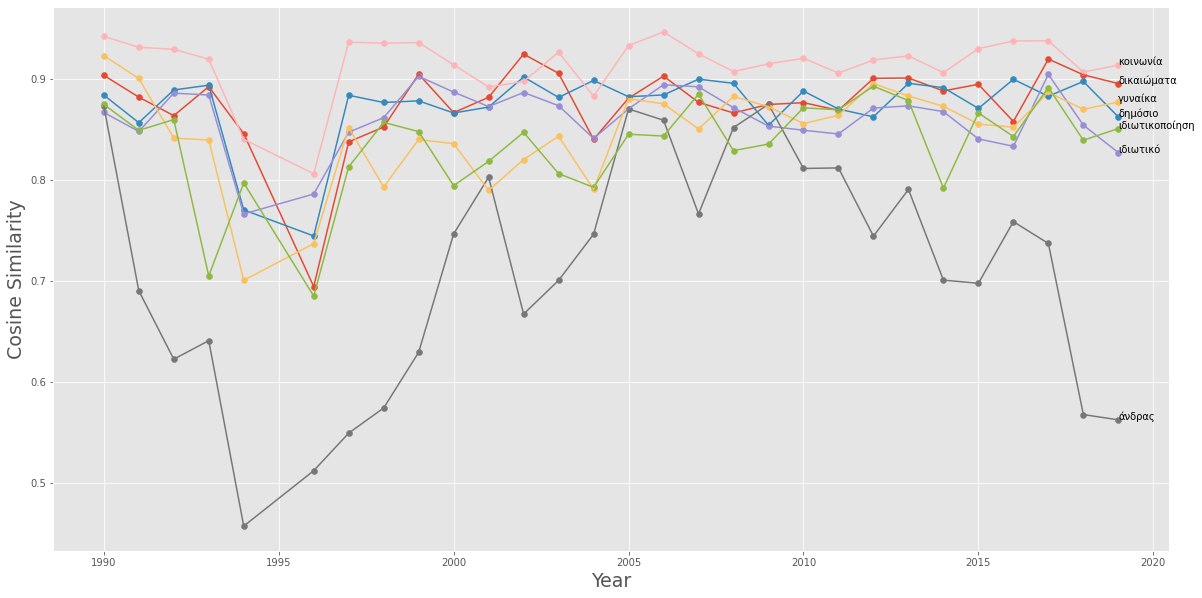

In [596]:

generic_topics = ['παιδεία', 'υγεία', 'οικονομία', 'δικαιοσύνη', 'εργασία', 
                  'περιβάλλον', 'πολιτισμός', 'εμπόριο', 'θρησκεία', 'τεχνολογία', 'άμυνα']

generic_words = ['δικαιώματα', 'δημόσιο', 'ιδιωτικό', 'άνδρας', 'γυναίκα', 'ιδιωτικοποίηση', 'κοινωνία'], 
                  'πολίτης', 'αστυνομία', 'πατρίδα', 'ευρωπαϊκή']

topic_swift = defaultdict(list)
years = list(range(1990,1995))+list(range(1996,2020))
print(years)

for topic in tq.tqdm(generic_words):
    topic_swift[topic] = []
    
    for y in years:
        if y==1994:
            topic_swift[topic].append(sim(models[y],models[y+2],topic))
        elif y==1995:
            continue
        else:
            topic_swift[topic].append(sim(models[y],models[y+1],topic))


plot_swift(list(years), topic_swift)

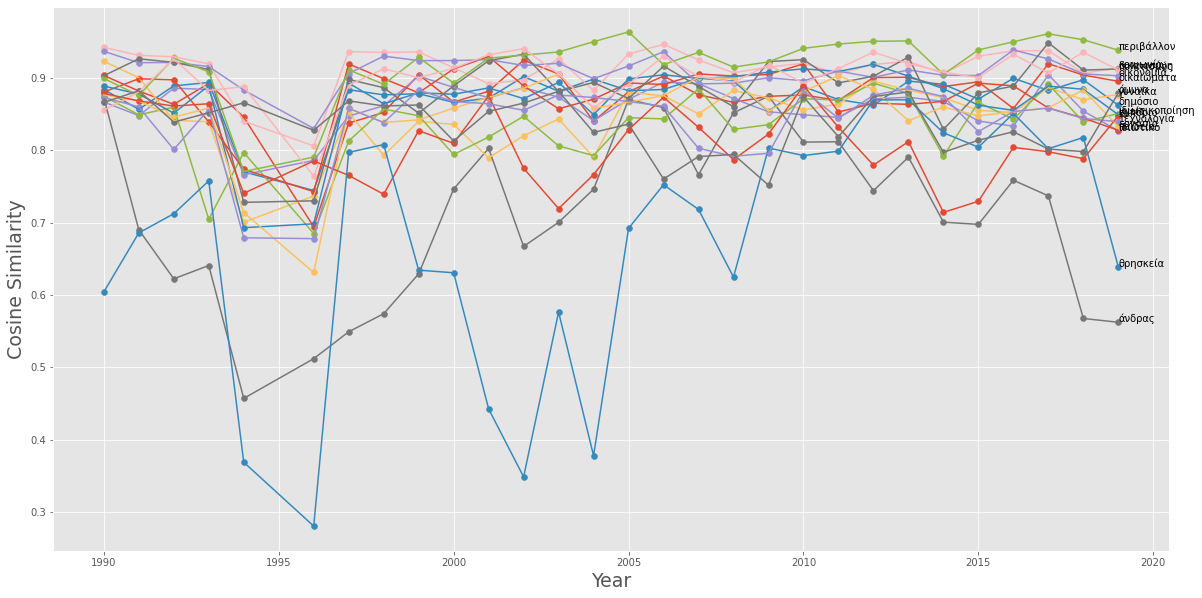

In [597]:
for topic in tq.tqdm(generic_topics):
    topic_swift[topic] = []
    
    for y in years:
        if y==1994:
            topic_swift[topic].append(sim(models[y],models[y+2],topic))
        elif y==1995:
            continue
        else:
            topic_swift[topic].append(sim(models[y],models[y+1],topic))


plot_swift(list(years), topic_swift)
